In [2]:
from noisy_zsc.game import NoisyBailLeverGame
from noisy_zsc.heuristic_learner import ArgmaxAgent, Argmaxof2Agent, StubbornAgent, argmax_of_2
from noisy_zsc.learner.PPOAgent import PPOAgent
import torch as T
import numpy as np
import matplotlib.pyplot as plt
import wandb
from copy import deepcopy
import random
from collections import deque
import pandas as pd
import csv
import seaborn as sns
import os

os.chdir('../sigma_sweep/')
os.getcwd()

'/data/engs-oxfair3/bras5206/noisy-ZSC/tests/sigma_sweep'

In [3]:
def eval_IPPO_xplay(n_games,
    env: NoisyBailLeverGame,
    agent1: PPOAgent,
    agent2: PPOAgent):

    score_list = []
    epi_list = []
    avg_score = 0
    N = 20

    for epi in range(n_games):
        obs, _ = env.reset()
        
        done = False
        score = 0
        
        epi_list.append(epi)

        while not done:
            action1, prob, val = agent1.choose_action(obs[0])
            action2, prob, val = agent2.choose_action(obs[1])
    
            reward, done = env.step(action1, action2)

            obs_ = env.get_obs()
        
            score += reward

            #agent1.remember(obs[0], action1, prob, val, reward, done)
            #agent2.remember(obs[1], action2, prob, val, reward, done)

            #if n_steps % N == 0:
            #    agent1.learn(ent_weight=config.ent_weight)
            #    agent2.learn(ent_weight=config.ent_weight)
            obs = obs_
        
        score_list.append(score)
        #print(f"episode {epi} -- score {score}")
    avg_score = np.mean(score_list)

    return avg_score


### get cross play matrix ###

def xplay_mat(sigma1, sigma2):
    sigma = 5.
    bail_payoff = 5.
    mean_payoffs = [5., 5., 5.]
    episode_length = 1

    lr = 0.00024
    clip = 0.2 # typical 0.1-0.3
    batch_size = 64
    n_epochs = 10

    n_games = 1000

    env = NoisyBailLeverGame(mean_payoffs, bail_payoff, sigma, sigma1, sigma2, episode_length)
    n_actions = len(env.true_payoffs)
    obs_dim = env.obs_dim()
    
    df = pd.DataFrame(columns = ['seed1', 'seed2', 'value'])
    for seed1 in range(15):
        for seed2 in range(15):
            agent1_actor_chkpt = f"models/actor_sigma1{sigma1}_sigma2{sigma2}_seed{seed1}_1"
            agent1_critic_chkpt = f"models/critic_sigma1{sigma1}_sigma2{sigma2}_seed{seed1}_1"
            agent2_actor_chkpt = f"models/actor_sigma1{sigma1}_sigma2{sigma2}_seed{seed2}_1"
            agent2_critic_chkpt = f"models/critic_sigma1{sigma1}_sigma2{sigma2}_seed{seed2}_1"
            agent1 = PPOAgent(n_actions=n_actions, batch_size=batch_size, 
                    alpha=lr, n_epochs=n_epochs, 
                    input_dims=obs_dim)
            agent2 = deepcopy(agent1)
            agent1.load_models(agent1_actor_chkpt, agent1_critic_chkpt)
            agent2.load_models(agent2_actor_chkpt, agent2_critic_chkpt)

            score = eval_IPPO_xplay(n_games,env,agent1,agent2)
            entry = pd.DataFrame.from_dict({'seed1': [seed1], 
                'seed2': [seed2], 'value':[score]})        
            df = pd.concat([df, entry], ignore_index = True)

    return df


                

/home/bras5206/.conda/envs/pytorch/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


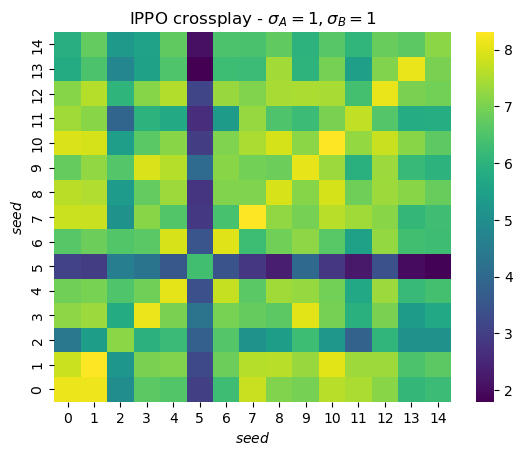

In [4]:
df = xplay_mat(sigma1=1, sigma2=1)
pivot_11 = df.pivot(index='seed1', columns='seed2', values='value')
ax = sns.heatmap(pivot_11, fmt='.1f', cmap='viridis')
ax.invert_yaxis()
plt.title(f"IPPO crossplay - $\sigma_A=1,\sigma_B=1$")
plt.xlabel("$seed$")
plt.ylabel("$seed$")
plt.savefig('IPPO_xplay_1_1.png')
plt.show()

/home/bras5206/.conda/envs/pytorch/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


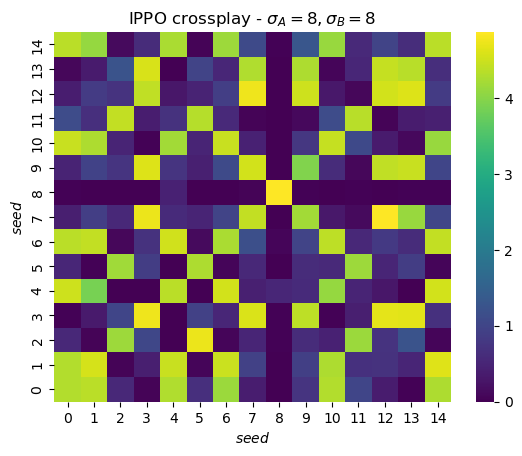

In [5]:
df_8_8 = xplay_mat(sigma1=8, sigma2=8)
pivot_88 = df_8_8.pivot(index='seed1', columns='seed2', values='value')
ax = sns.heatmap(pivot_88, fmt='.1f', cmap='viridis')
ax.invert_yaxis()
plt.title(f"IPPO crossplay - $\sigma_A=8,\sigma_B=8$")
plt.xlabel("$seed$")
plt.ylabel("$seed$")
plt.savefig('IPPO_xplay_8_8.png')
plt.show()

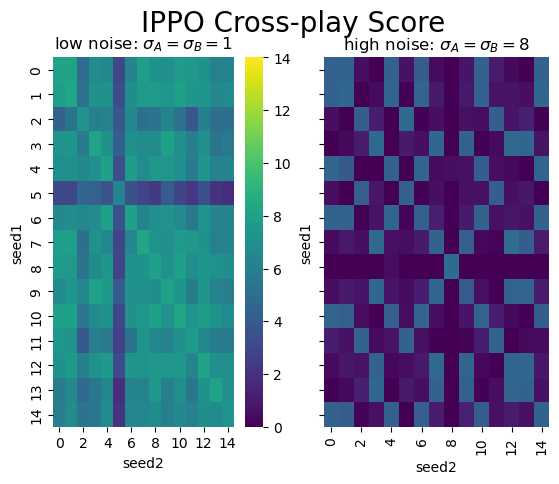

In [8]:
fig, (ax0,ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.heatmap(pivot_88,ax=ax0,vmin=0,vmax=14,cmap='viridis',cbar=False)
sns.heatmap(pivot_11,ax=ax1,vmin=0,vmax=14,cmap='viridis',cbar=True)
ax0.set_title('low noise: $\sigma_A=\sigma_B=1$')

ax1.set_title('high noise: $\sigma_A=\sigma_B=8$')
fig.suptitle('IPPO Cross-play Score',fontsize=20)
#saving figure for publication if needed
#plt.savefig('save.tif', dpi=300)
plt.show()